In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin

from catboost import CatBoostClassifier

In [2]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    """
    График ROC-кривой
    """
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")
    
def plot_precision_recall_curve(precision, recall, model_name="", color=None):
    """
    График Precision-Recall кривой
    """    
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

In [3]:
#Загрузим данные
train_path = 'data_feat_train.pkl'
test_path = 'data_feat_test.pkl'

In [4]:
train_df = pd.read_pickle(train_path)

In [5]:
train_df.head()

,id,vas_id,buy_time_vas,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,time_delta
0,540968.0,8.0,1.537132e+09,0.0,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495834,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.580612,-0.065583,-0.700765,-192.026962,239.787094,-1005.230652,1245.017822,-89.504288,-119.724358,-3.512019,33.247475,-36.759495,-7.896282,-7.997875,-10.697456,-28.551693,-17.130283,-16.088985,-26.171711,-5.331295,1.041298,-3.745251,-1.671324,-0.001656,9.318354,15.117334,0.174766,-0.108162,0.028356,-0.017576,-0.165662,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275913,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,-0.212137,-11.955315,-1.019293,-1.473446,0.37916,-1006.426575,1242.881104,0.03201,0.196143,236.454514,848.953552,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211945,-119.674408,-208.886353,0.031923,-0.030451,0.104871,1.381836,5.318359,1.426717,-0.468443,-0.017283,-190.670380,5.856777,7.27741,2.174027,5.064012,0.0,-1.276187,-0.020137,-0.042636,-11.480350,-59.370804,34.036369,-17.888325,0.138539,-0.317164,-0.007024,-0.143269,-14.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,1.321786,-0.014542,-0.009508,-8.183167,35.756905,-14.320085,-40.801491,-5.961228,33.187763,-12.614497,-26.671719,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793638,-1.932758,-5.008096,-15.978121,-36.800720,-9.354808,-25.320370,-0.034569,-0.163184,-109.036400,0.533317,-1.929048,-0.623737,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712891,-45175.257812,-0.622901,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,969818880.0,-49.224079,-4.405604e+08,-120441800.0,-8.634002,-1.465191,-33.30238,810.871033,270.227509,-0.364694,-0.133771,-0.209468,269.643494,-109.884567,364.308990,41.631718,938.889282,-108.409744,-504.437317,-53.617977,-12.295406,-845.37384,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0,4838400.0
1,1454121.0,4.0,1.531688e+09,0.0,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880859,566.551880,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2764.330078,-1102.746338,-1661.5

-id - идентификатор абонента

-vas_id - подключаемая услуга

-buy_time_vas - время покупки

-253 нормализованных анонимизированных признаков абонента

-time_delta - отражает разницу во времени 

-target - целевая переменная

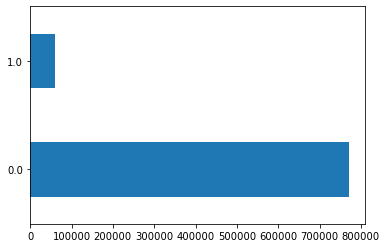

In [6]:
#Распределение целевой переменной
train_df['target'].value_counts().plot(kind='barh')
plt.show()

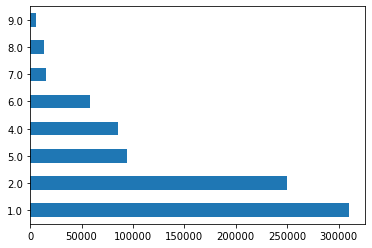

In [7]:
#Распределение услуг
train_df['vas_id'].value_counts().plot(kind='barh')
plt.show()

In [8]:
#time_delta - нормализуем от 0 до 1
w_sc = StandardScaler().fit_transform(train_df['time_delta'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

In [9]:
#Выделим целевую переменную
X = train_df.drop(['id','target','buy_time_vas'], axis=1)
y = train_df['target']

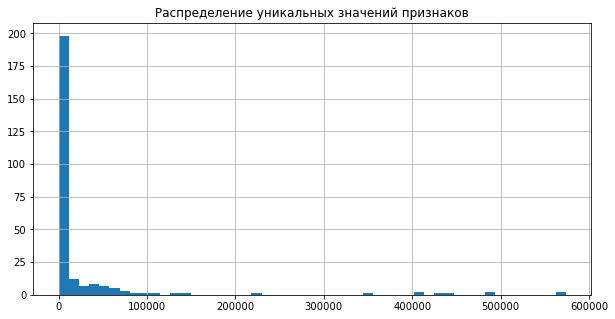

In [10]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=50, figsize=(10, 5));

In [11]:
#Распределим признаки
f_all = set(X_nunique.index.tolist())
f_const = set(X_nunique[X_nunique == 1].index.tolist())
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
f_other = f_all - (f_numeric | f_const )
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
X.loc[X['252']>1,:] = X['252'].value_counts().argmax()
f_categorical = f_categorical | {'252'}
f_weight = {'time_delta'}

Логистическая регрессия

In [15]:
from sklearn.model_selection import train_test_split

random_state= 42

train_idx, test_idx = train_test_split(X[f_ok].index, train_size=0.1, test_size=0.033, random_state=random_state)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]


In [17]:
from sklearn.linear_model import LogisticRegression

step_log_reg = ('log_reg', LogisticRegression(random_state=random_state, n_jobs=-1, max_iter=200))

In [18]:
# пайплайн для числовых признаков
f_num_pipepline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

# пайплайн для категориальных признаков
f_cat_pipepline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

# объединяющий пайплайн
preproc_pipeline = make_column_transformer(
    (f_num_pipepline, f_numeric),
    (f_cat_pipepline, f_categorical)
)

In [19]:
step_preproc = ("preproc", preproc_pipeline)

In [20]:
from sklearn.pipeline import Pipeline

bl_estimator = Pipeline([
    step_preproc,
    step_log_reg
])

In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):

    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [23]:
#метрика кросс-валидации
run_cv(bl_estimator, kfold_cv, X_train, y_train, model_name="Baseline");

Baseline: roc_auc = 0.84 (+/- 0.00)


In [24]:
%%time

# фитим пайплайн 
bl_estimator.fit(X_train, y_train)

# предиктим пайпланй на тестовом множестве
bl_y_pred = bl_estimator.predict_proba(X_test)[:,1]

Wall time: 2min 7s


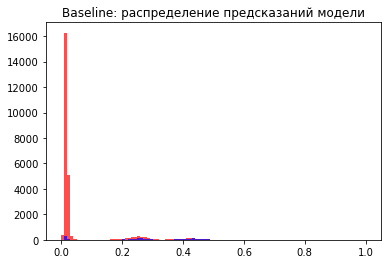

In [25]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(bl_y_pred[~y_test.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(bl_y_pred[y_test.astype(bool)], bins=100, color='b', alpha=0.7);

Roc и PR Кривые

In [26]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)

Baseline: AUC_ROC = 0.845


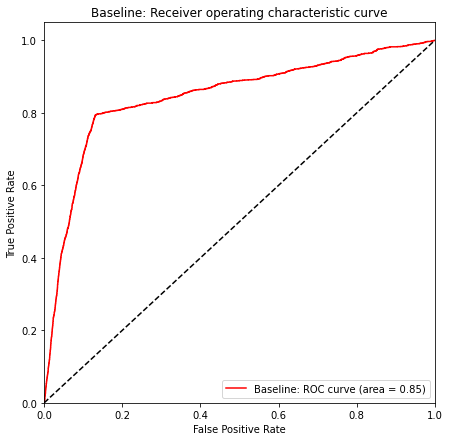

In [27]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.344


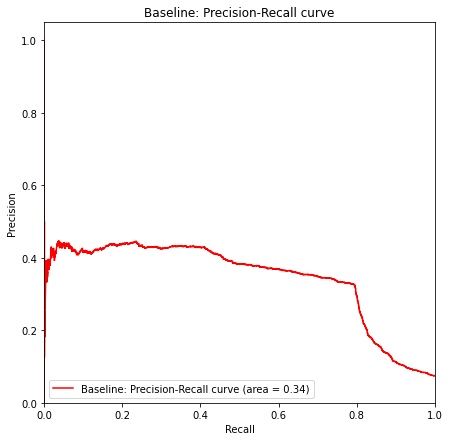

In [28]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

Матрица смежности

In [29]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[25353    59]
 [ 1992    41]]


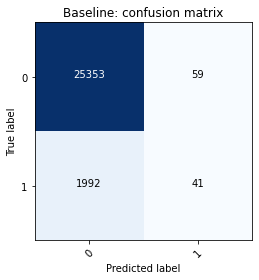

In [30]:
cm = confusion_matrix(y_test, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

In [31]:
from sklearn.metrics import classification_report

# выбирем порог 0.5
print(classification_report(y_test, bl_y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     25412
         1.0       0.41      0.02      0.04      2033

    accuracy                           0.93     27445
   macro avg       0.67      0.51      0.50     27445
weighted avg       0.89      0.93      0.89     27445



In [32]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(fp + tp)
recall = tp/(fn + tp)

accuracy = (tp + tn)/(fp + fn + tp + tn)

micro_avg_pr    = (tn + tp) / (fn + tn + fp + tp) # эквивалентно accuracy
macro_avg_pr    = (tn/(fn + tn) + tp/(fp + tp))/2 # берем среднее от precision по обоим классам

n_0 = (y_test == 0).sum()
n_1 = (y_test == 1).sum()
weighted_avg_pr = (n_0*tn/(fn + tn) + n_1*tp/(fp + tp))/(n_0 + n_1)

print("              accuracy = %.2f"   % float(accuracy))
print("           1 precision = %.2f"   % float(precision))
print("              1 recall = %.2f"   % float(recall))
print("   micro avg precision = %.2f "  % float(micro_avg_pr))
print("   macro avg precision = %.2f "  % float(macro_avg_pr))
print("weighted avg precision = %.2f "  % float(weighted_avg_pr))

              accuracy = 0.93
           1 precision = 0.41
              1 recall = 0.02
   micro avg precision = 0.93 
   macro avg precision = 0.67 
weighted avg precision = 0.89 


sklearn

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

In [34]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [35]:
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [36]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

In [37]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

259

In [39]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=random_state)
)

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [42]:
[k for k in lg_pipe.get_params().keys() if 'imputer' in k]

['pipeline__featureunion__numeric_features__simpleimputer',
 'pipeline__featureunion__numeric_features__simpleimputer__add_indicator',
 'pipeline__featureunion__numeric_features__simpleimputer__copy',
 'pipeline__featureunion__numeric_features__simpleimputer__fill_value',
 'pipeline__featureunion__numeric_features__simpleimputer__missing_values',
 'pipeline__featureunion__numeric_features__simpleimputer__strategy',
 'pipeline__featureunion__numeric_features__simpleimputer__verbose',
 'pipeline__featureunion__categorical_features__simpleimputer',
 'pipeline__featureunion__categorical_features__simpleimputer__add_indicator',
 'pipeline__featureunion__categorical_features__simpleimputer__copy',
 'pipeline__featureunion__categorical_features__simpleimputer__fill_value',
 'pipeline__featureunion__categorical_features__simpleimputer__missing_values',
 'pipeline__featureunion__categorical_features__simpleimputer__strategy',
 'pipeline__featureunion__categorical_features__simpleimputer__verbos

In [43]:
param_grid = {
    "logisticregression__penalty": ['l1', 'l2'],
    "logisticregression__C": [0.01, 0.1, 5.0]
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.84

Best parameters set found on development set:

{'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

Grid scores on development set:

nan (+/-nan) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1'}
0.839 (+/-0.005) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
0.840 (+/-0.004) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l1'}
0.840 (+/-0.005) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}



C:\Users\igora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
lg_gsc.best_params_

{'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

Отбор признаков

In [45]:
from sklearn.feature_selection import SelectFromModel

In [47]:
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=random_state), threshold=1e-5),
)

In [48]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(27445, 259)

In [49]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

C:\Users\igora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(27445, 259)

In [52]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=random_state), threshold=1e-5),
    LogisticRegression(random_state=random_state)
)

In [53]:
# исследуем при разных количествах призаков, независимо от threshold
param_grid = [
    {"selectfrommodel__max_features": [None, 5, 10, 50, 100, 150], "selectfrommodel__threshold": [-np.inf]},
    {"selectfrommodel__threshold": [1e-5]},
]

lg_fs_gsc = run_grid_search(lg_fs_pipe, X_train, y_train, param_grid, kfold_cv)

C:\Users\igora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best roc_auc score: 0.84

Best parameters set found on development set:

{'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.840 (+/-0.005) for {'selectfrommodel__max_features': None, 'selectfrommodel__threshold': -inf}
0.840 (+/-0.009) for {'selectfrommodel__max_features': 5, 'selectfrommodel__threshold': -inf}
0.842 (+/-0.012) for {'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}
0.841 (+/-0.009) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.843 (+/-0.005) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.841 (+/-0.004) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.840 (+/-0.005) for {'selectfrommodel__threshold': 1e-05}



C:\Users\igora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Финальная модель

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [56]:
# создадим пайплайн с отбром признаков через лог.регрессию с регуляризаией l2, в конце эстимейтром  GradientBoostingClassifier
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=random_state), threshold=1e-5),
    GradientBoostingClassifier()
)

In [57]:
[k for k in gb_fs_pipe.get_params().keys() if 'grad' in k]

['gradientboostingclassifier',
 'gradientboostingclassifier__ccp_alpha',
 'gradientboostingclassifier__criterion',
 'gradientboostingclassifier__init',
 'gradientboostingclassifier__learning_rate',
 'gradientboostingclassifier__loss',
 'gradientboostingclassifier__max_depth',
 'gradientboostingclassifier__max_features',
 'gradientboostingclassifier__max_leaf_nodes',
 'gradientboostingclassifier__min_impurity_decrease',
 'gradientboostingclassifier__min_impurity_split',
 'gradientboostingclassifier__min_samples_leaf',
 'gradientboostingclassifier__min_samples_split',
 'gradientboostingclassifier__min_weight_fraction_leaf',
 'gradientboostingclassifier__n_estimators',
 'gradientboostingclassifier__n_iter_no_change',
 'gradientboostingclassifier__presort',
 'gradientboostingclassifier__random_state',
 'gradientboostingclassifier__subsample',
 'gradientboostingclassifier__tol',
 'gradientboostingclassifier__validation_fraction',
 'gradientboostingclassifier__verbose',
 'gradientboostingcla

In [58]:
param_grid = {
    "selectfrommodel__threshold": [-np.inf, 1e-05],
    
    "gradientboostingclassifier__max_depth": [1, 5],
    "gradientboostingclassifier__n_estimators": [10, 100]
}

gb_fs_gsc = run_grid_search(gb_fs_pipe, X_train, y_train, param_grid, kfold_cv)

C:\Users\igora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best roc_auc score: 0.86

Best parameters set found on development set:

{'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.833 (+/-0.008) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.833 (+/-0.008) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': 1e-05}
0.849 (+/-0.008) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': -inf}
0.849 (+/-0.008) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': 1e-05}
0.855 (+/-0.009) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.855 (+/

Сравнение моделей

In [59]:
# модель бейзлайн
lg_fs_pipe_final = lg_fs_gsc.best_estimator_

# модель с предобработкой признаков и лог.регрессией с отбором признаков
lg_fs_pipe_final.fit(X_train, y_train)

# модель с предобработкой признаков, лог.регсрессией с отбором признаков и градиентным бустингом
lg_fs_pred = lg_fs_pipe_final.predict_proba(X_test)[:,1]

C:\Users\igora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\igora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [60]:
print(classification_report(y_test, lg_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     25412
         1.0       0.44      0.01      0.03      2033

    accuracy                           0.93     27445
   macro avg       0.68      0.51      0.49     27445
weighted avg       0.89      0.93      0.89     27445



In [61]:
gb_fs_pipe_final = gb_fs_gsc.best_estimator_

gb_fs_pipe_final.fit(X_train, y_train)

gb_fs_pred = gb_fs_pipe_final.predict_proba(X_test)[:,1]

C:\Users\igora\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
print(classification_report(y_test, gb_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     25412
         1.0       0.37      0.04      0.08      2033

    accuracy                           0.92     27445
   macro avg       0.65      0.52      0.52     27445
weighted avg       0.89      0.92      0.89     27445



Вывод: модель с градиентым бустингом дает значения precision (0.93), recall (0.99) и f1-score(0.96), то есть не лучше первой модели.